# Argo one filter scale

In [23]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import argopy
import scipy.ndimage as filter
import cartopy.crs as ccrs
import cartopy
import xrft
import scipy
import matplotlib

### Things to work on:
- Compare Dhruv's rigourous filtering method from the Filtering_and_Fourier_transforms repo to my functions that use scipy.gaussian_filter1d. Are the results identical?
- If they are not identical (and honestly maybe even if they are), make new ones with the same method as Dhruv's repo
- Use these functions to perform the above calculations about "MKE" and "EKE" on one scale:
    - Pass temperature signal through filter at l=100m, then square the results <-- MKE
    - Square the temperature signal, pass it through filter at l=100m, then subtract MKE <-- EKE

### Useful functions, Argo

In [121]:
def get_ds_interp(ds,depth_min,depth_max,sample_max):
    median_dp=ds.PRES.where(ds.PRES<depth_max).where(ds.PRES>depth_min).diff('N_LEVELS').median('N_LEVELS')
    ind_rate=median_dp.where(median_dp<sample_max,drop=True).N_PROF
    ds_sel=ds.sel(N_PROF=ind_rate)
    ds_interp=ds_sel.argo.interp_std_levels(np.arange(depth_min,depth_max,2))
    ds_interp=ds_interp.sortby(ds_interp.N_PROF)
    
    number=np.arange(0,len(ds_interp.N_PROF))
    ds_interp.coords['N_PROF_NEW']=xr.DataArray(number,dims=ds_interp.N_PROF.dims)
    return ds_interp

def get_ds_filt(ds_interp,first,last,num,variable='TEMP'):
    temp_sigmas=np.logspace(first,last,num)
    sigmas=np.empty(num)
    
    for n,sig in enumerate(temp_sigmas):
        sigmas[n]=sig/4/np.sqrt(12)
    
    temp=np.zeros((ds_interp.N_PROF.shape[0],ds_interp.PRES_INTERPOLATED.shape[0],num))
    for n in range(0,num):
        temp[:,:,n]=filter.gaussian_filter1d(ds_interp[variable],sigma=sigmas[n],mode='nearest')

    ds_filt=xr.DataArray(temp,dims=['N_PROF','PRES_INTERPOLATED','FILT_SCALE'],
             coords={'N_PROF':ds_interp.N_PROF,'PRES_INTERPOLATED':ds_interp.PRES_INTERPOLATED,'FILT_SCALE':sigmas})
    
    number=np.arange(0,len(ds_filt.N_PROF))
    ds_filt['N_PROF_NEW']=xr.DataArray(number,dims=ds_filt.N_PROF.dims)
    return ds_filt

def get_var(ds_interp,ds_filt,variable='TEMP'):
    var=np.zeros(len(ds_filt.FILT_SCALE))
    for n,sig in enumerate(ds_filt.FILT_SCALE):
        prof=ds_filt.sel(FILT_SCALE=sig)
        var[n]=(prof-ds_interp[variable]).var()
    return var

### Useful functions, glider

In [25]:
def glider_ds_filt(ds_interp,first,last,num,variable='CT'):
    temp_sigmas=np.logspace(first,last,num)
    sigmas=np.empty(num)
    for n,sig in enumerate(temp_sigmas):
        sigmas[n]=sig/4/np.sqrt(12)
        
    temp_filt=np.zeros((ds_interp.ctd_pressure.shape[0],ds_interp.dives.shape[0],num))
    for n in range(0,num):
        temp_filt[:,:,n]=filter.gaussian_filter1d(ds_interp[variable],sigma=sigmas[n],mode='nearest')
    ds_filt=xr.DataArray(temp_filt,dims=['ctd_pressure','dives','filt_scale'],
        coords={'ctd_pressure':ds_interp.ctd_pressure,'dives':ds_interp.dives,'filt_scale':sigmas})
    return ds_filt

def glider_var(ds_interp,ds_filt,variable='CT'):
    var=np.zeros(len(ds_filt.filt_scale))
    for n,sig in enumerate(ds_filt.filt_scale):
        prof_filt=ds_filt.sel(filt_scale=sig)
        var[n]=(prof_filt-ds_interp.CT).var()
    return var

### Load in data

In [137]:
#glider data
ds_660_grid = xr.open_dataset('ctd_660_vert_4m_binned_29_june_2021.nc')
gselect=ds_660_grid.sel(dives=slice(50,450),ctd_pressure=slice(200,900))
gselect_filt=glider_ds_filt(gselect,1,4,50)
gselect_var=glider_var(gselect,gselect_filt)

#argo box
box=xr.open_dataset("202206_lon:(30,40)_lat:(-55,-50).nc")
aselect=get_ds_interp(box,200,2000,4)
aselect_filt=get_ds_filt(aselect,1,4,50)
aselect_var=get_var(aselect,aselect_filt)

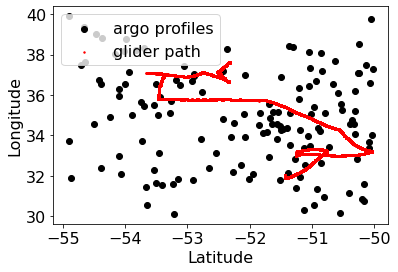

In [138]:
plt.scatter(aselect.LATITUDE,aselect.LONGITUDE,color='black',label='argo profiles')
plt.scatter(gselect.latitude,gselect.longitude,color='r',s=2,label='glider path')
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.legend()

Text(0.5, 1.0, 'Argo Box')

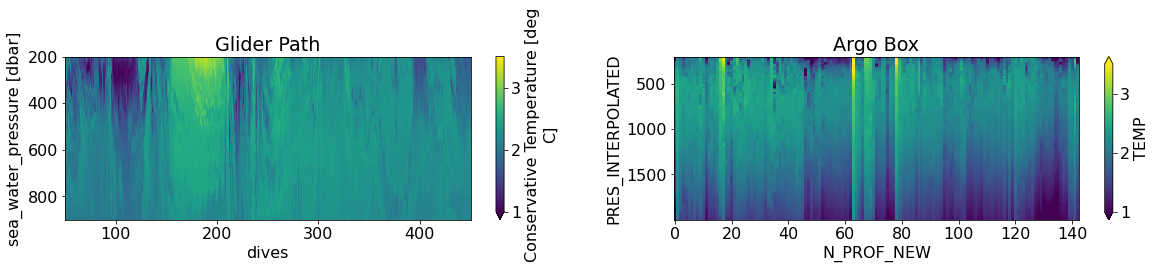

In [139]:
plt.figure(figsize=(20,3))

plt.subplot(1,2,1)
gselect.CT.plot(x='dives',y='ctd_pressure',vmin=1,vmax=3.5)
plt.gca().invert_yaxis()
plt.title('Glider Path')

plt.subplot(1,2,2)
aselect.TEMP.plot(x='N_PROF_NEW',y='PRES_INTERPOLATED',vmin=1,vmax=3.5)
plt.gca().invert_yaxis()
plt.title('Argo Box')

## MKE/EKE method from Steinberg paper

These eqations are for energy at one spatial scale, where the eddy kinetic energy at scales smaller than the filter scale (EKE) and mean kinetic energy at scales larger than the filter scale (MKE) are:

$$
MKE = <u>^2
$$
$$
EKE = <u^2> - <u>^2
$$

(based on this paper: [Steinberg](https://journals.ametsoc.org/view/journals/phoc/52/8/JPO-D-21-0269.1.xml))

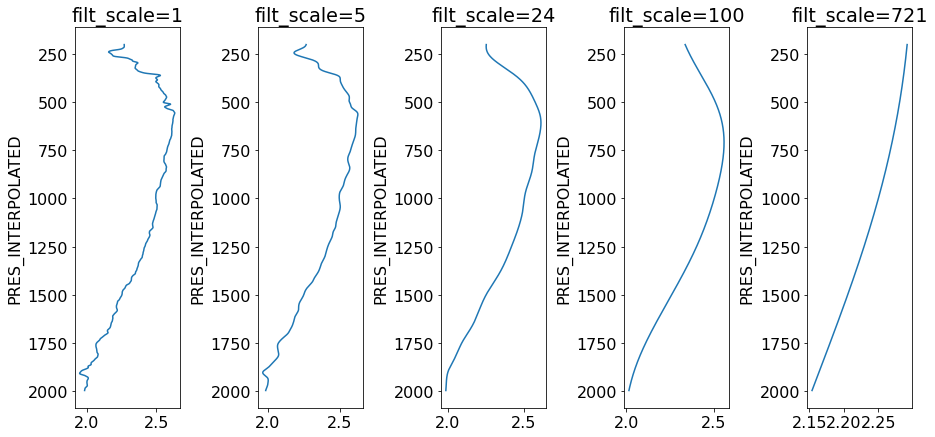

In [146]:
#want to look at how much each filter smooths

plt.figure(figsize=(15,7))

plt.subplot(1,5,1)
aselect_filt.isel(N_PROF=1).isel(FILT_SCALE=5).plot(y='PRES_INTERPOLATED')
plt.gca().invert_yaxis()
plt.title('filt_scale={}'.format(int(aselect_filt.FILT_SCALE.isel(FILT_SCALE=5))))

plt.subplot(1,5,2)
aselect_filt.isel(N_PROF=1).isel(FILT_SCALE=15).plot(y='PRES_INTERPOLATED')
plt.gca().invert_yaxis()
plt.title('filt_scale={}'.format(int(aselect_filt.FILT_SCALE.isel(FILT_SCALE=15))))

plt.subplot(1,5,3)
aselect_filt.isel(N_PROF=1).isel(FILT_SCALE=25).plot(y='PRES_INTERPOLATED')
plt.gca().invert_yaxis()
plt.title('filt_scale={}'.format(int(aselect_filt.FILT_SCALE.isel(FILT_SCALE=25))))

plt.subplot(1,5,4)
aselect_filt.isel(N_PROF=1).isel(FILT_SCALE=35).plot(y='PRES_INTERPOLATED')
plt.gca().invert_yaxis()
plt.title('filt_scale={}'.format(int(aselect_filt.FILT_SCALE.isel(FILT_SCALE=35))))

plt.subplot(1,5,5)
aselect_filt.isel(N_PROF=1).isel(FILT_SCALE=-1).plot(y='PRES_INTERPOLATED')
plt.gca().invert_yaxis()
plt.title('filt_scale={}'.format(int(aselect_filt.FILT_SCALE.isel(FILT_SCALE=-1))))

plt.subplots_adjust(wspace=0.75)

In [175]:
l=35
aselect_filt_l=aselect_filt.isel(FILT_SCALE=l)

MKE=aselect_filt_l**2

Text(0.5, 1.0, 'Argo Box')

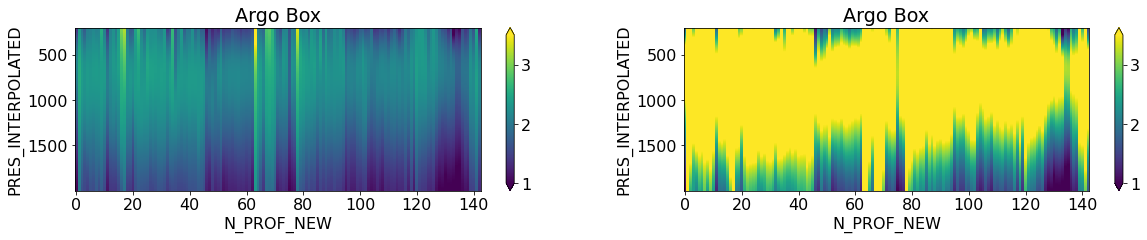

In [190]:
plt.figure(figsize=(20,3))

plt.subplot(1,2,1)
aselect_filt_l.plot(x='N_PROF_NEW',y='PRES_INTERPOLATED',vmin=1,vmax=3.5)
plt.gca().invert_yaxis()
plt.title('Argo Box')

plt.subplot(1,2,2)
MKE.plot(x='N_PROF_NEW',y='PRES_INTERPOLATED',vmin=1,vmax=3.5)
plt.gca().invert_yaxis()
plt.title('Argo Box')

In [191]:
#need to square signal, then filter this
#running into problems because get_ds_filt assumes it's reading in full array
####not just the TEMP info
u2=aselect.TEMP**2
u2_filt=

#EKE = u2_filt - MKE

KeyError: 'TEMP'